# Using Slisemap on the Air Quality dataset

In this notebook we will demonstrate how to use Slisemap on the Air Quality dataset with a classification task.

In [1]:
import sys

import numpy as np
import pandas as pd

from pathlib import Path
from urllib.request import urlretrieve

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.insert(0, "..")

from slisemap import Slisemap
from slisemap.local_models import logistic_regression, logistic_regression_loss

### Objectives

These are the objectives of this notebook:

- Demonstrate how to use a different type of white box model with Slisemap.
- Discuss the use of subsampling.
- Demonstrate how to tweak parameters.
- Investigate the solution and the data.
- Demonstrate how to add data not in the initial subsample.

## Data

The Air Quality dataset contains 7355 hourly instances of 12 different air quality measurements, one of which is used as a dependent variable (CO) and the others as covariates. Since this notebook demonstrates classification, we split the $y$-values into two clusters based on the median.

In [2]:
# As in previous noteboook, load the dataset (download it if necessary).
path = Path("data") / "AQ_cleaned_version.csv"
if not path.exists():
    urlretrieve(
        "https://raw.githubusercontent.com/edahelsinki/drifter/master/TiittanenOHP2019-code/data/AQ_cleaned_version.csv",
        path,
    )
AQ = pd.read_csv(path)

In [3]:
"""
The Air Quality dataset is cleaned and preprocessed as in:

    Oikarinen E, Tiittanen H, Henelius A, Puolamäki K (2021)
    Detecting virtual concept drift of regressors without ground truth values.
    Data Mining and Knowledge Discovery 35(3):726-747, DOI 10.1007/s10618-021-00739-7]
"""
columns = [
    "PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)", "NOx(GT)", "PT08.S3(NOx)", "NO2(GT)",
    "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH",
]
names = [
    "CO(sensor)", "C6H6(GT)", "NMHC(sensor)", "NOx(GT)", "NOx(sensor)", "NO2(GT)",
    "NO2(sensor)", "O3(sensor)", "Temperature", "Relative hum.", "Absolute hum.",
]

# X contains the covariates, y is the target variable and names are column names.
X0 = AQ[columns].to_numpy()
y0 = AQ["CO(GT)"].to_numpy()

In [4]:
pd.DataFrame(np.concatenate([y0.reshape((-1,1)), X0], axis=1), columns=["CO(GT)"]+names)

,CO(GT),CO(sensor),C6H6(GT),NMHC(sensor),NOx(GT),NOx(sensor),NO2(GT),NO2(sensor),O3(sensor),Temperature,Relative hum.,Absolute hum.
0,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...
7350,3.1,1314.25,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
7351,2.4,1162.50,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
7352,2.4,1142.00,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
7353,2.1,1002.50,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [5]:
# We will now split the target variables to two binary classes
# Straight through the middle based on target median
y = (y0 > np.median(y0)).astype(float)
y = np.stack((y, 1 - y), 1)
X = StandardScaler().fit_transform(X0)

### Black box model

Now, as in the previous notebook, we will use a black box model for the target value. For that we build a random forest classifier using `sklearn.ensemble.RandomForestClassifier`. Note that we use the predicted probabilities instead of the predicted labels!

In [6]:
random_forest = RandomForestClassifier(random_state=42).fit(X, y)
y2 = random_forest.predict_proba(X)[0]

## Slisemap

Since we are now dealing with a classification task we replace the default white box model (linear regression) in Slisemap with logistic regression. Furthermore, 7355 data items is more than necessary for visualisation purposes, so we subsample 1500 data items. If results for all data items is needed we can add them later (using the structure from the 1500 samples for faster training).

In [7]:
# Subsample the data
size = 1500
X, X_test, y2, y_test, X0, _ = train_test_split(
    X, y2, X0, train_size=size, test_size=size, stratify=y[:, 0], random_state=42
)

Now we create a Slisemap object (without an intercept) and optimise the solution. Since this example takes a while to optimise, we instead load a precalculated Slisemap object from disk.

In [8]:
if Path("sm-02.v1.dump").exists():
    sm = Slisemap.load("sm-02.v1.dump")
else:
    # Create a Slisemap object with lasso regularisation
    sm = Slisemap(
        X,
        y2,
        lasso=0.0001,
        radius=3.5,
        intercept=False,
        local_model=logistic_regression,
        local_loss=logistic_regression_loss,
        coefficients=X.shape[1],
        random_state=42,
    )
    # Optimise the solution
    %time sm.optimise()

    sm.cpu()
    sm.save("sm-02.v1.dump")

print(f"Loss: {sm.value()}")

CPU times: user 1h 9min 30s, sys: 35.1 s, total: 1h 10min 5s
Wall time: 23min 12s
Loss: 3.223054885864258


### Tweaking

If we plot the solution we see that the linear models are not very sparse even though we used lasso/L1 regularisation:

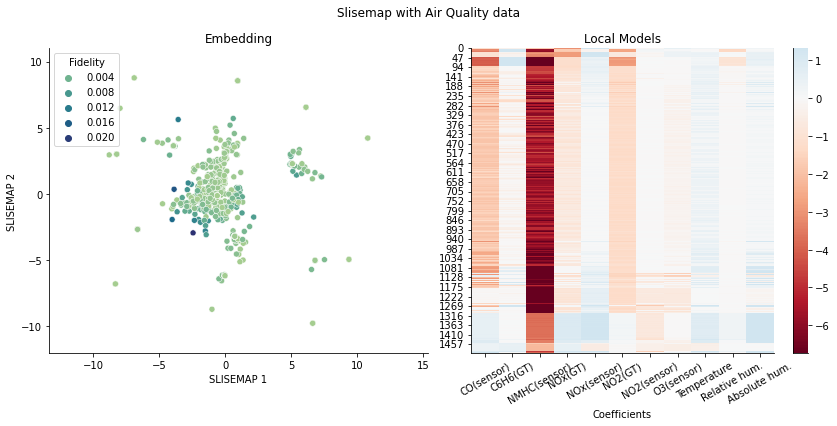

In [9]:
sm.plot(title="Slisemap with Air Quality data", variables=names)

This is beacuse we used quite weak regularisation. We can increase the regularisation strength without creating a new `Slisemap` object (remember to re-optimise):

In [10]:
if Path("sm-02.v2.dump").exists():
    sm = Slisemap.load("sm-02.v2.dump")
else:
    sm.lasso = 0.005
    %time sm.optimise()

    sm.cpu()
    sm.save("sm-02.v2.dump")

CPU times: user 23min 13s, sys: 9.04 s, total: 23min 22s
Wall time: 5min 54s


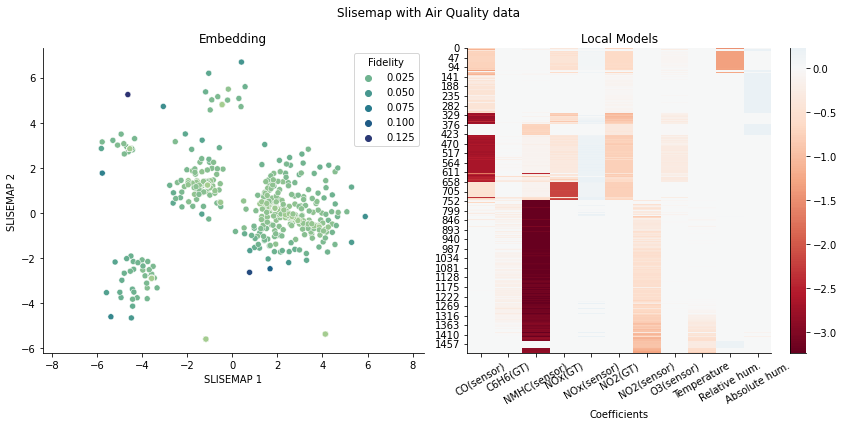

In [11]:
sm.plot(title="Slisemap with Air Quality data", variables=names)

Now the local models are more sparse (more coefficients are zero). This makes them easier to interpret. Additionally, the clusters in the embedding are more distinct, due to the larger differences in the local models. 

### Visualisations

Next we will add some jitter and plot the local models in a bar plot:

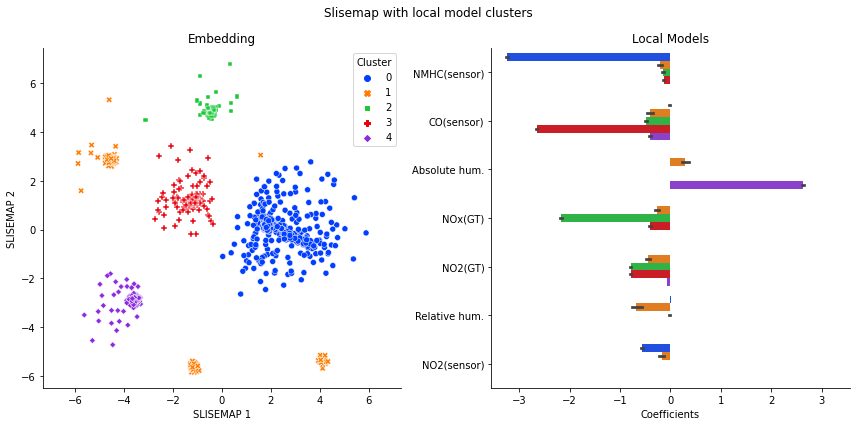

In [12]:
clusters = 5
bars = 7
sm.plot(
    title="Slisemap with local model clusters",
    clusters=clusters,
    bars=bars,
    jitter=0.1,
    variables=names,
)

This makes it easier to see which clusters and local models are connected, and to compare the magnitudes of the coefficients of the local models.

Next we plot the distribution of attribute values for the clusters (note the use of unscaled data):

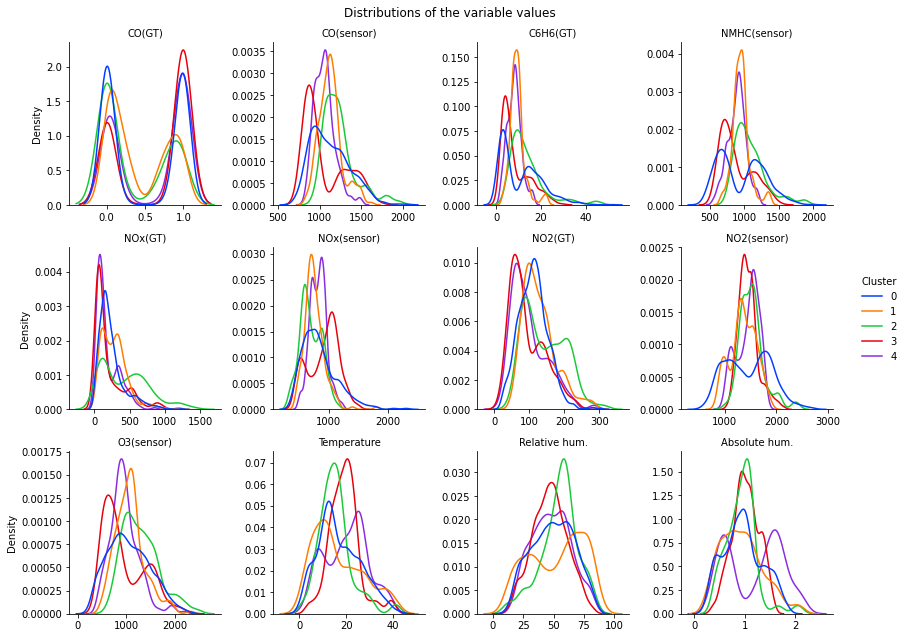

In [13]:
sm.plot_dist(
    X=X0,
    title="Distributions of the variable values",
    clusters=clusters,
    variables=names,
    targets="CO(GT)",
    height=3,
)

Here we see that the clusters do not only have different local models, there are also differences in the distributions of the variables.

## Unseen test data

Initially we subsampled the data into the training set consisting of 1500 data items and the testing set of 1500. We will now examine how data items not used for training the Slisemap solution could be added to the embedding. First we take 7 random data items and show what their fidelities would be if we were to copy the embedding and local model from one training data item (here we plot every possible choice).

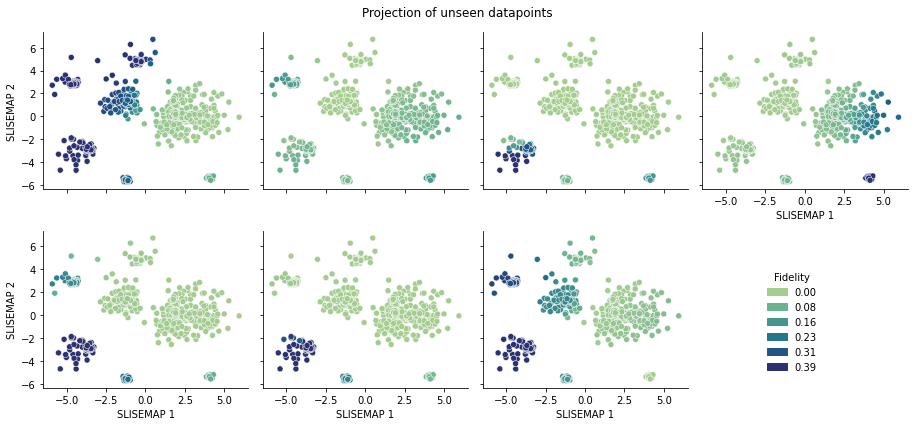

In [14]:
np.random.seed(42)
sel = np.random.randint(0, X_test.shape[0], 7)
sm.plot_position(
    X_test[sel],
    y_test[sel],
    title="Projection of unseen datapoints",
    height=3,
    jitter=0.1,
)

Here we see that the local models in the different clusters are not suitable for every unseen data item.

Next we will optimise new embeddings and new local models for all the unseen data, using the structure from the training data as a guide:

In [15]:
if Path("BZ-02.v3.npz").exists():
    BZ = np.load("BZ-02.v3.npz")
    B_test = BZ["B_test"]
    Z_test = BZ["Z_test"]
else:
    %time B_test, Z_test = sm.fit_new(X_test, y_test)

    np.savez_compressed("BZ-02.v3.npz", B_test=B_test, Z_test=Z_test)

CPU times: user 12min 23s, sys: 2min 9s, total: 14min 33s
Wall time: 4min


Note that this is much faster than training the solution from scratch.

Finally, lets plot the embeddings of the new and old data in the same plot:

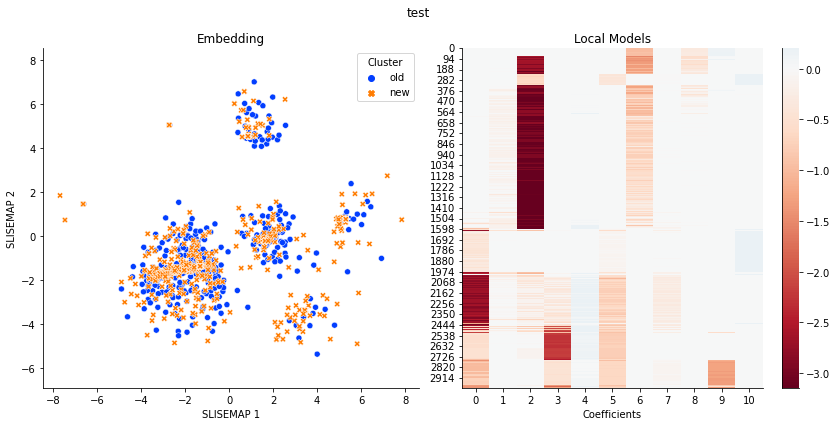

In [16]:
sm.plot(
    B=np.concatenate((sm.get_B(), B_test), 0),
    Z=np.concatenate((sm.get_Z(), Z_test), 0),
    title="test",
    clusters=["old"] * sm.n + ["new"] * B_test.shape[0],
    jitter=0.0,
)

As we can see the structure of the unseen data matches that of the training data.

## Conclusions

In this notebook we have looked at a simple classifier use case for Slisemap, and demonstrated the various plots that can be used to to visualise, explore, and investigate the solution and the data.